In [1]:
from typing import Tuple
import pandas as pd
import numpy as np
import tensorflow as tf

from smot.training import kaggle_data

In [2]:
titanic_train = pd.read_csv(kaggle_data.kaggle_data_path("titanic", "train.csv"))
titanic_test = pd.read_csv(kaggle_data.kaggle_data_path("titanic", "train.csv"))
# PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked

# PassengerId: int
# dataset id of passenger.

# Survived: bool
# 0 = No, 1 = Yes
# Did the passenger survive?

# Pclass: category
# Ticket class of the passenger
# 1 = 1st, 2 = 2nd, 3 = 3rd

# Sex: category
# "male", "female"
# Gender of the passenger

# Name: str
# Name of the passenger.

# Age: float
# Age in years of the passenger.
# Age is fractional if less than 1.
# If the age is estimated, is it in the form of xx.5

# SibSp: int
# of siblings / spouses aboard the Titanic
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)

# Parch: int
# of parents / children aboard the Titanic
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them.

# Ticket: int
# Ticket number.

# Fare: int
# Ticket price.

# Cabin: int
# Cabin number.

# Embarked: category
# C = Cherbourg, Q = Queenstown, S = Southampton
# Port of embarkation.

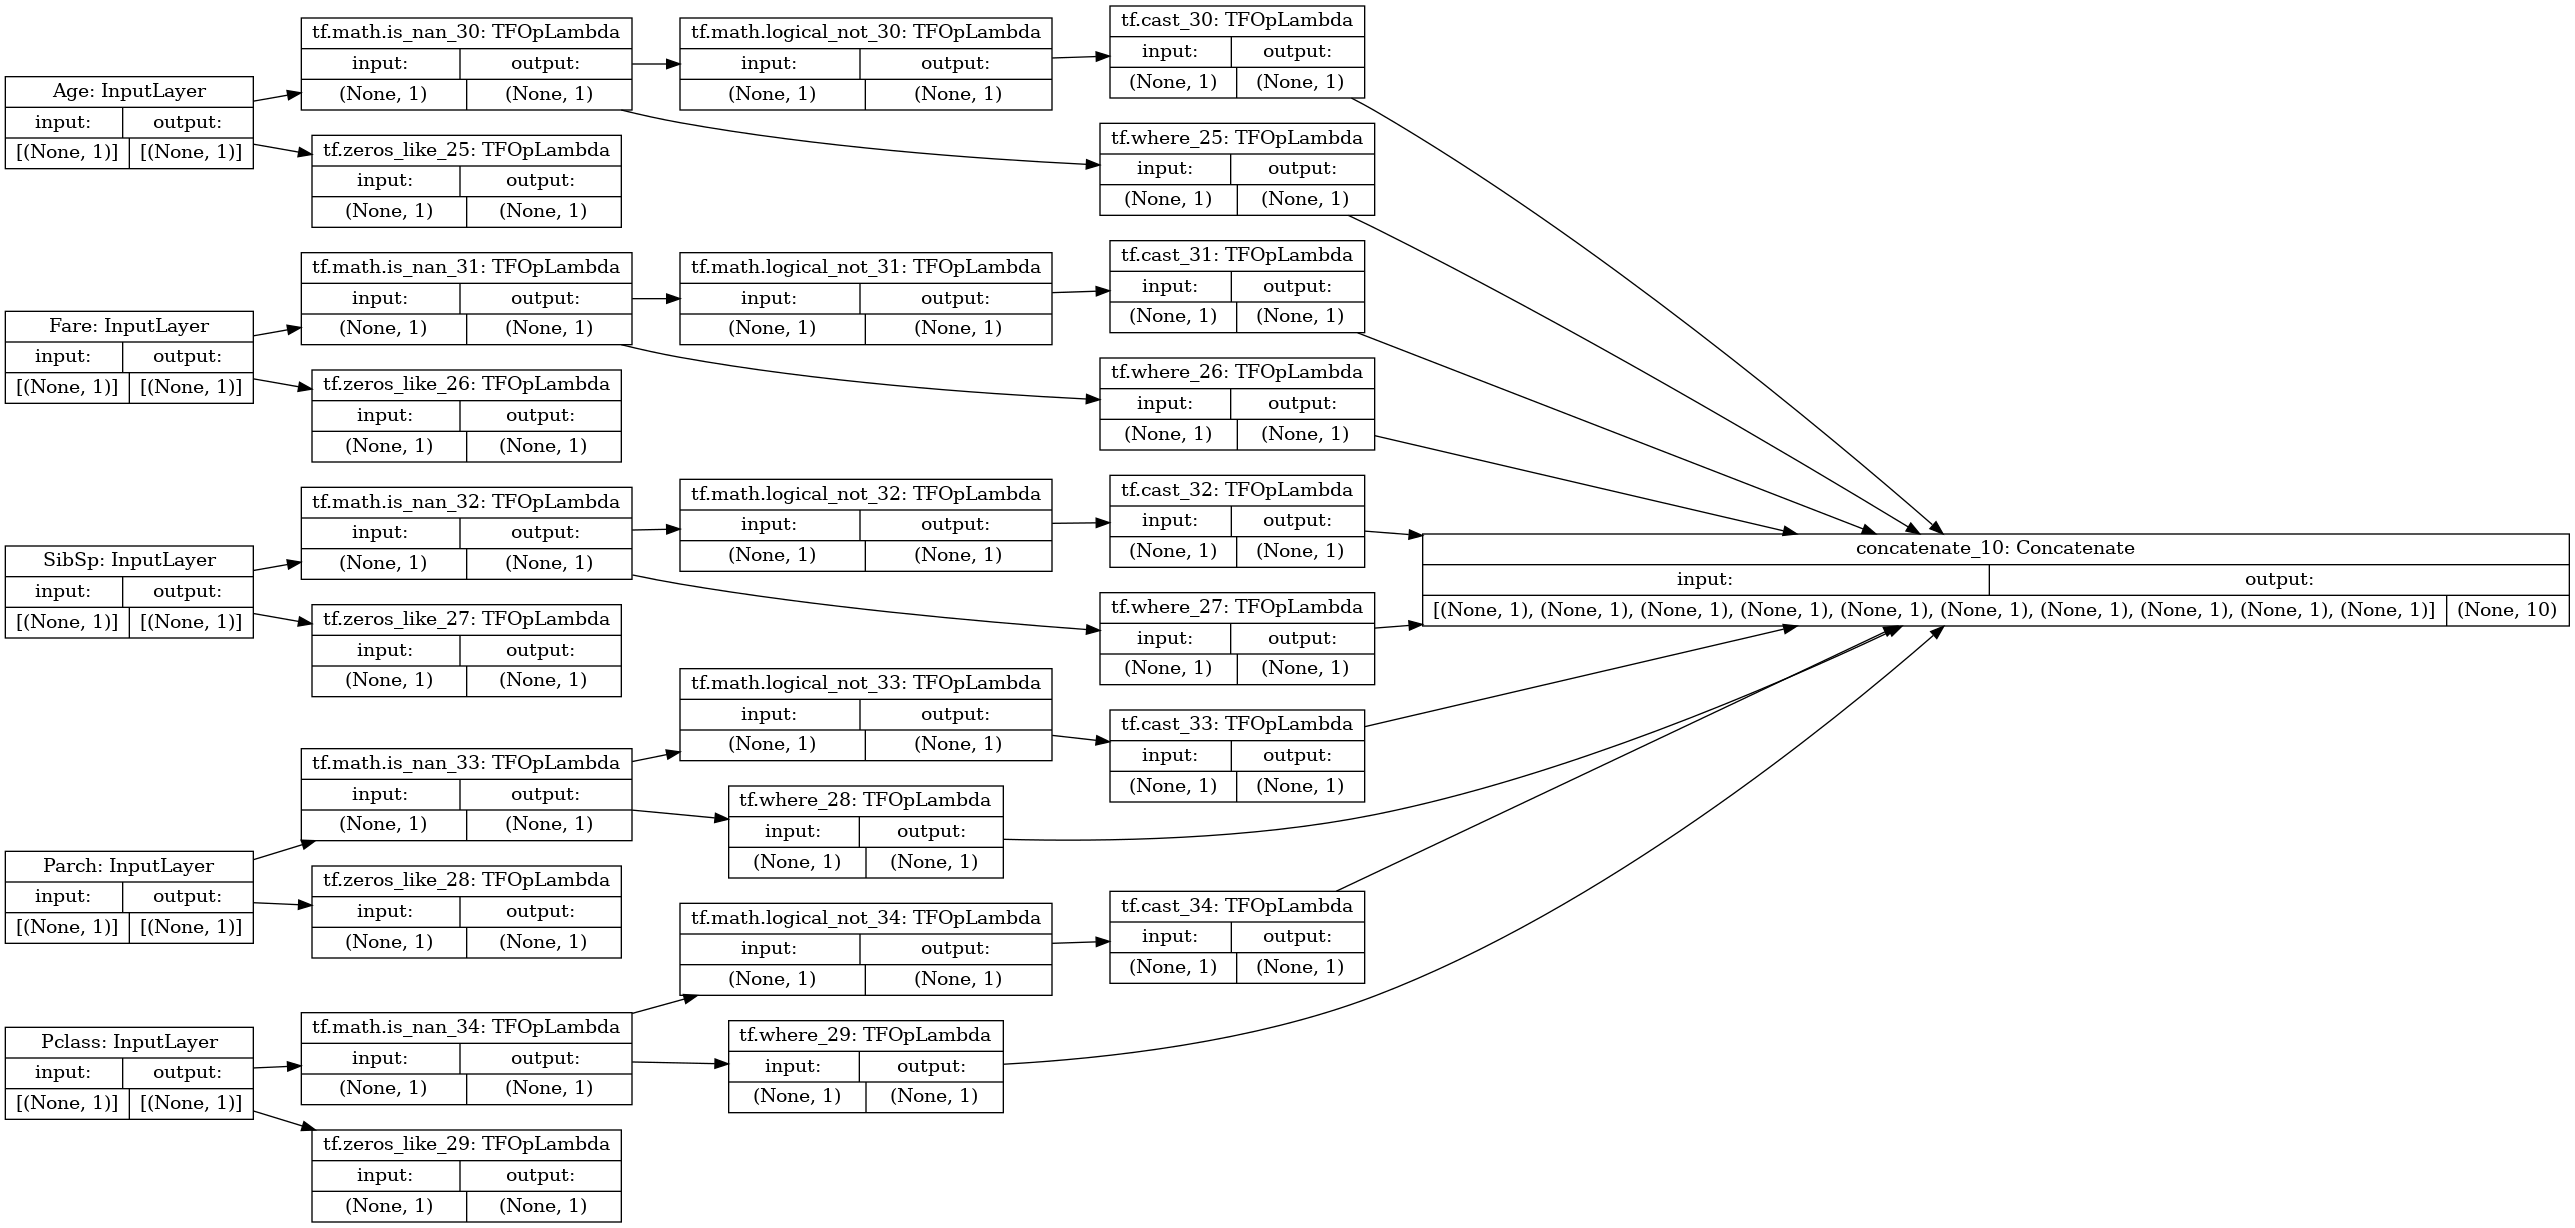

In [38]:
# id, survived, age, class (1-hot), sex (1-hot)

def split_titanic_dataset(source: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split a Titanic problem dataset into a (Features DataFrame, Labels DataFrame) tuple.

    :param source: source DataFrame.
    :return: a (Features DataFrame, Labels DataFrame) tuple.
    """
    labels = source["Survived"]

    # features = source[["Age", "Fare", "SibSp", "Parch", "Pclass"]]

    features = {
        name: np.array(value)
        for name, value in source[["Age", "Fare", "SibSp", "Parch", "Pclass"]].items()
    }

    return features, labels

train_features, train_labels = split_titanic_dataset(titanic_train)
val_features, val_labels = split_titanic_dataset(titanic_test)

inputs = {
    k: tf.keras.Input(shape=(1,), name=k, dtype=tf.float32)
    for k,v in train_features.items()
    if v.dtype != object
}

numeric_inputs = {
    k: v
    for k,v in inputs.items()
    if v.dtype==tf.float32
}

finite_numeric_inputs = []
numeric_masks = []

def nan_mask(input):
    is_nan = tf.math.is_nan(input)
    finite_input = tf.where(is_nan, tf.zeros_like(input), input)
    mask = tf.cast(tf.math.logical_not(is_nan), tf.float32)
    return mask, finite_input

for k, v in numeric_inputs.items():
    mask_v, finite_v = nan_mask(v)

    finite_numeric_inputs.append(finite_v)
    numeric_masks.append(mask_v)


#x = tf.keras.layers.Concatenate()(list(finite_numeric_inputs))
#norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
#norm_layer.adapt(train_features[numeric_inputs.keys()])
#normalized_numeric_inputs = norm_layer(x)


preprocessed_inputs = []
#preprocessed_inputs.append(normalized_numeric_inputs)
preprocessed_inputs.extend(finite_numeric_inputs)
preprocessed_inputs.extend(numeric_masks)

preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

preprocess_model = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(preprocess_model, rankdir='LR', show_shapes=True, show_layer_names=True)

In [32]:
processed_data = preprocess_model(train_features)
processed_data

<tf.Tensor: shape=(891, 10), dtype=float32, numpy=
array([[22.    ,  7.25  ,  1.    , ...,  1.    ,  1.    ,  1.    ],
       [38.    , 71.2833,  1.    , ...,  1.    ,  1.    ,  1.    ],
       [26.    ,  7.925 ,  0.    , ...,  1.    ,  1.    ,  1.    ],
       ...,
       [ 0.    , 23.45  ,  1.    , ...,  1.    ,  1.    ,  1.    ],
       [26.    , 30.    ,  0.    , ...,  1.    ,  1.    ,  1.    ],
       [32.    ,  7.75  ,  0.    , ...,  1.    ,  1.    ,  1.    ]],
      dtype=float32)>

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Age (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Fare (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Parch (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Pclass (InputLayer)             [(None, 1)]          0                                            
___________________________________________________________________________________________

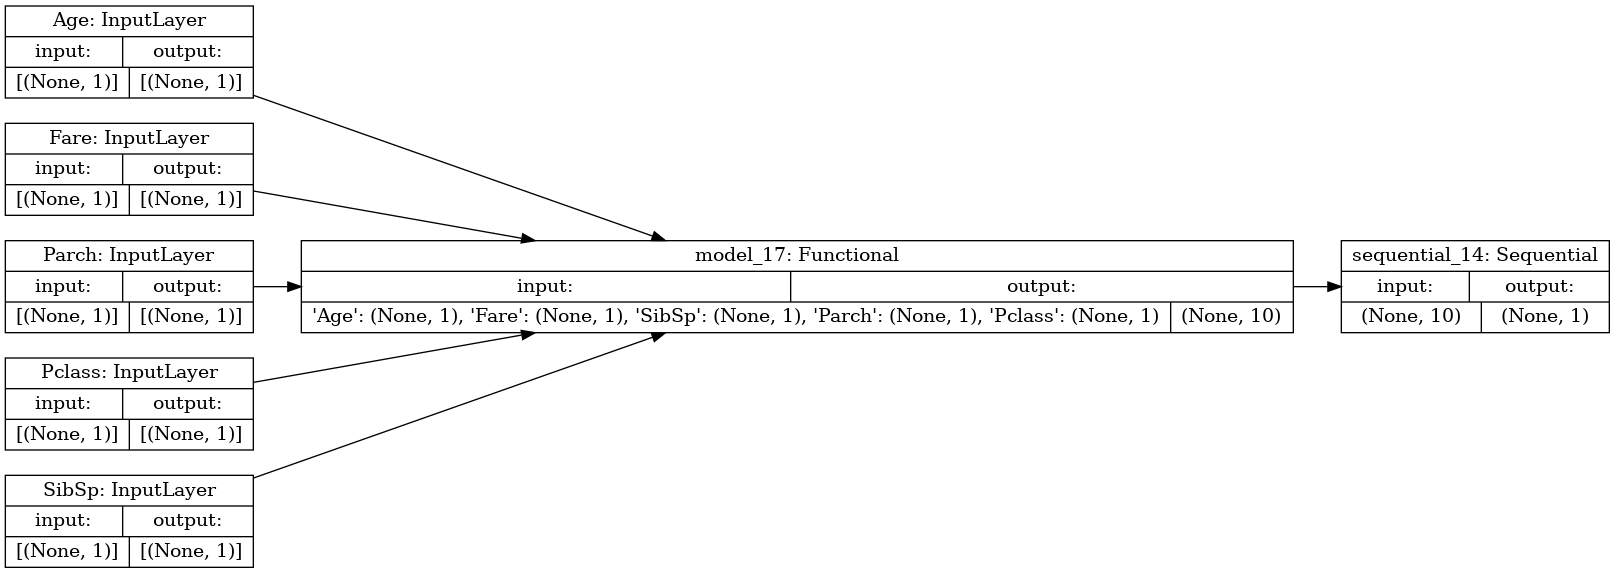

In [48]:
def titanic_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(
        loss=tf.losses.BinaryCrossentropy(
            from_logits=True,
            label_smoothing=0.05,
        ),
        optimizer=tf.optimizers.Adam(),
        metrics=['accuracy'],
    )

    return model

model = titanic_model(preprocess_model, inputs)

model.summary()

tf.keras.utils.plot_model(model, rankdir='LR', show_shapes=True)


In [49]:
model.fit(
    train_features,
    train_labels.to_numpy(),
    validation_data=(val_features, val_labels),
    verbose=1,
    epochs=50,
)


Epoch 1/50
28/28 [==============================] - 0s 8ms/step - loss: 3.2004 - accuracy: 0.5429 - val_loss: 1.2588 - val_accuracy: 0.5589
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 2.7396 - accuracy: 0.5654 - val_loss: 1.2147 - val_accuracy: 0.6308
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 2.2805 - accuracy: 0.5869 - val_loss: 0.7048 - val_accuracy: 0.6251
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 2.0638 - accuracy: 0.6013 - val_loss: 1.6343 - val_accuracy: 0.6375